# Project Idea 1: 

- Make a simplifying assumption between the **loan issuance date** and application dates,
convert the approved loans into the formats of rejected loan applications.
- Use supervised technique and clustering, describe (reverse engineering) 
the loan approval criterion of **Lending Club**.

    - Challenges: The aggregated data has more than $20M$ samples. This is
        beyond the coverage of many ML algorithms. How do you design an apporach 
        which allows you to train on such a large size data? The problem is
        particularly serious for training **pooled** models.
    - When you apply supervised technique, it might involve imbalanced classification.
    How would you handle 'im-balanced dataset' like this?
    
- Are there poor performing approved loans which should be rejected?
- What is the business impact (pros and cons) of rejecting such non-performing loans?
</a><br>
# Structure: 
- <a href="#preprocessing">Data Processing Function
- <a href="#imbalance">Handling Imbalanced Data</a><br>

- <a href="#ml">Machine Learning</a><br>
    - Unsupervised Machine Learning  
        - <a href="#kmeans">K Means</a><br> 
    - Supervised Machine Learning      
        - <a href="#decision">Decision Tree</a><br>
        - <a href="#rf">Random Forest</a><br>
        - <a href="#svm">SVM</a><br>
        - <a href="#xgboost">XGBoost</a><br>
        - <a href="#logistic">Logistic Regression</a><br>
        - <a href="#naive">Naive Bayes Classifier</a><br>
        - <a href="#neighbor">Nearest Neighbor</a><br>


In [2]:
import numpy as np
import pandas as pd
import matplotlib as plt
from sklearn.utils import resample

%matplotlib inline
pd.options.display.max_columns = None
pd.options.display.max_rows = 100

pd.options.display.max_columns = None
pd.options.display.max_rows = 100
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split



In [18]:
df_raw_accepted = pd.read_csv('accepted_2007_to_2018Q4.csv.gz')
df_raw_rejected = pd.read_csv('rejected_2007_to_2018Q4.csv.gz')

C:\Users\Laptop2\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Data Processing Function

In [1]:
def data_process(df_accepted,df_rejected):
    
    accepted = df_accepted.copy()
    rejected = df_rejected.copy()
    
    # Processing accepted data 
    accepted = accepted[['loan_amnt', 'purpose', 'dti',
       'addr_state', 'emp_length', 'issue_d',
       'loan_status', 'last_fico_range_high','last_fico_range_low']]
    
    accepted['issue_d'] = pd.to_datetime(accepted['issue_d'])
    accepted['app_year'] = accepted['issue_d'].dt.year
    accepted['app_month'] = accepted['issue_d'].dt.month

    accepted['risk_score'] = (accepted['last_fico_range_high'] + accepted['last_fico_range_low'])/2
    accepted = accepted.drop(columns = ['issue_d','last_fico_range_high','last_fico_range_low'])


    accepted['loan_status'] =1
            
    
    # Processing rejected data 
    rejected = rejected.iloc[:,1:9]
    rejected = rejected.rename(columns={"Amount Requested": "loan_amnt", "Application Date": "app_date", "Loan Title": "purpose",
                             "Risk_Score": "risk_score", "Debt-To-Income Ratio": "dti", "Zip Code": "zip_code",
                             "State": "addr_state", "Employment Length": "emp_length"})
    rejected['loan_status'] = 0
    
    rejected['purpose'] = rejected['purpose'].str.replace(r'(^.*consolidation.*$)', 'debt_consolidation')
    rejected['purpose'] = rejected['purpose'].str.replace(r'(^.*loan.*$)', 'debt_consolidation')
    rejected['purpose'] = rejected['purpose'].str.replace(r'(^.*debt.*$)', 'debt_consolidation')
    rejected['purpose'] = rejected['purpose'].str.replace(r'(^.*card.*$)', 'credit_card')
    rejected['purpose'] = rejected['purpose'].str.replace(r'(^.*credit.*$)', 'credit_card')
    rejected['purpose'] = rejected['purpose'].str.replace(r'(^.*house.*$)', 'house')
    rejected['purpose'] = rejected['purpose'].str.replace(r'(^.*business.*$)', 'small_business')
    rejected['purpose'] = rejected['purpose'].str.replace(r'(^.*car.*$)', 'car')
    rejected['purpose'] = rejected['purpose'].str.replace(r'(^.*education.*$)', 'education')
    
    
    rejected['purpose'] = np.where(rejected['purpose'].isin(['house', 'credit_card', 'major_purchase', 'debt_consolidation',
       'other', 'moving', 'small_business', 'home_improvement',
       'vacation', 'medical', 'renewable_energy', 'car', 'wedding']), rejected['purpose'], 'other')

    rejected['app_date'] = pd.to_datetime(rejected['app_date'])
    rejected['app_year'] = rejected['app_date'].dt.year
    rejected['app_month'] = rejected['app_date'].dt.month

    rejected = rejected.drop(columns = 'app_date')
    rejected = rejected.drop(columns = 'zip_code')
    
    rejected['dti'] = rejected['dti'].str.replace('%','')
    
    # Merge accepted and rejected data for later process
    df_processed = pd.concat([accepted, rejected], sort=True)
    

    # Convert categorical to numerical-- 10 means more than 10 years 
    df_processed['emp_length'] = df_processed['emp_length'].str.extract('(\d+)')


    # Missing Values: risk_score, emp_length, dti
    df_processed['emp_length'] = df_processed['emp_length'].fillna(0)
    df_processed['emp_length'] = df_processed['emp_length'].astype(int)
    df_processed['risk_score'] = df_processed['risk_score'].fillna(0)
    df_processed['dti'] = df_processed['dti'].fillna(0)
    df_processed['dti'] = df_processed['dti'].astype(float)
    df_processed = df_processed.dropna()

    df_processed = pd.get_dummies(df_processed)

    return df_processed

# Handling Imbalanced Data
#### Handle Inbalanced data by downsampling the majority class (which is the rejected).

In [ ]:
#reject is the majority class. downsample reject to treat the imbalanced classification problem. 

reject_downsampled = resample(df_raw_rejected,
                                replace = False, # sample without replacement
                                n_samples = len(df_raw_accepted), # match minority n
                                random_state = 27) # reproducible results
reject_downsampled.to_csv('reject_downsampled.csv')



In [ ]:
reject_downsampled=pd.read_csv('reject_downsampled.csv')

#### Split train and test set. Test set will be used for testing result of the best model selected in the future.  

In [ ]:
train_set_from_reject_downsampled= reject_downsampled.sample(frac=0.75, random_state=0)
test_set_from_reject_downsampled = reject_downsampled.drop(train_set_from_reject_downsampled.index)

In [ ]:
train_set_from_reject_downsampled.to_csv('train_set_from_reject_downsampled.csv')
test_set_from_reject_downsampled.to_csv('test_set_from_reject_downsampled.csv')

In [3]:
train_set_from_reject_downsampled=pd.read_csv('train_set_from_reject_downsampled.csv', index_col=0)
test_set_from_reject_downsampled=pd.read_csv('test_set_from_reject_downsampled.csv', index_col=0)

C:\Users\Laptop2\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [ ]:
train_set_from_accepted_raw= df_raw_accepted.sample(frac=0.75, random_state=0)
test_set_from_accepted_raw = df_raw_accepted.drop(train_set_from_accepted_raw.index)

In [5]:
train_set_from_accepted_raw.to_csv('train_set_from_accepted_raw.csv')
test_set_from_accepted_raw.to_csv('test_set_from_accepted_raw.csv')

In [6]:
train_set_from_accepted_raw=pd.read_csv('train_set_from_accepted_raw.csv',index_col=0)
test_set_from_accepted_raw=pd.read_csv('test_set_from_accepted_raw.csv',index_col=0)

C:\Users\Laptop2\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\Laptop2\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (1,20,50,60,119,130,131,132,135,136,137,140,146,147,148) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#### Work on the train set for model selection

In [7]:
df_processed = data_process(train_set_from_accepted_raw, train_set_from_reject_downsampled)

In [ ]:
#if there is no enough memory, you can write to csv 
#and restart kernel to read file instead
df_processed.to_csv('df_processed.csv',index=False )

In [ ]:
df_processed=pd.read_csv('df_processed.csv')

In [8]:
#sub sample the df_processed to prepare for the machine learning model
sampled_df_processed=df_processed.sample(frac=0.06, random_state=0)

In [9]:
# # The predicted column is "loan_status" , split the data into training and test sets.
x_m = sampled_df_processed.drop(['loan_status'], axis=1)
y_m = sampled_df_processed.loc[:,'loan_status']
X_train, X_test, y_train, y_test = train_test_split(x_m, y_m, test_size=0.2, random_state=42)

 <p><a name="ml"></a></p>
 
 # Machine Learning
 
- Unsupervised Machine Learning  
    - <a href="#kmeans">K Means</a><br> 
    
- Supervised Machine Learning      
    - <a href="#decision">Decision Tree</a><br>
    - <a href="#rf">Random Forest</a><br>
    - <a href="#svm">SVM</a><br>
    - <a href="#xgboost">XGBoost</a><br>
    - <a href="#logistic">Logistic Regression</a><br>
    - <a href="#naive">Naive Bayes Classifier</a><br>
    - <a href="#neighbor">Nearest Neighbor</a><br>
</a><br>
- Working on
    Neural Networks
</a><br>
- Links: 
    - https://github.com/perryrjohnson/Walk-Score/blob/master/feature%20engineering.ipynb
    - https://towardsdatascience.com/an-implementation-and-explanation-of-the-random-forest-in-python-77bf308a9b76

In [10]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score


from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB

from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, recall_score, precision_score, accuracy_score, roc_curve
from sklearn.metrics import classification_report

import seaborn as sns
import matplotlib.pyplot as plt

 <p><a name="kmeans"></a></p>
 
 ### K Means
 
 Link: https://towardsdatascience.com/machine-learning-algorithms-part-9-k-means-example-in-python-f2ad05ed5203
</a></p> http://benalexkeen.com/k-means-clustering-in-python/
 
 k-means clustering is very sensitive to scale due to its reliance on Euclidean distance so be sure to normalize data if there are likely to be scaling problems.
If there are some symmetries in your data, some of the labels may be mis-labelled
It is recommended to do the same k-means with different initial centroids and take the most common label.

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(X_train)
X_train = pd.DataFrame(scaled_df, columns=X_train.columns)

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_train)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans = kmeans.fit(X_train)
labels = kmeans.predict(X_train)
C = kmeans.cluster_centers_

y_pred_kmeans = kmeans.predict(X_test)


 <p><a name="decision"></a></p>
 
 ### Decision Tree 

In [11]:
from sklearn.tree import DecisionTreeClassifier

# Make a decision tree and train
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

print(f'Model Accuracy: {tree.score(X_train, y_train)}')

y_pred = tree.predict(X_test)
print("Test Accuracy:",metrics.accuracy_score(y_test, y_pred))

Model Accuracy: 1.0
Test Accuracy: 0.9506303295407073


In [12]:
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)
print(classification_report(y_test, y_pred))


[[19443   938]
 [ 1071 19241]]
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     20381
           1       0.95      0.95      0.95     20312

    accuracy                           0.95     40693
   macro avg       0.95      0.95      0.95     40693
weighted avg       0.95      0.95      0.95     40693



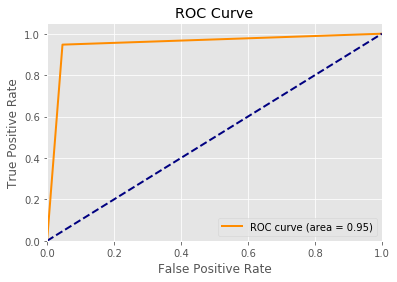

In [13]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

y_predict_probabilities = tree.predict_proba(X_test)[:,1]

fpr, tpr, _ = roc_curve(y_test, y_predict_probabilities)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

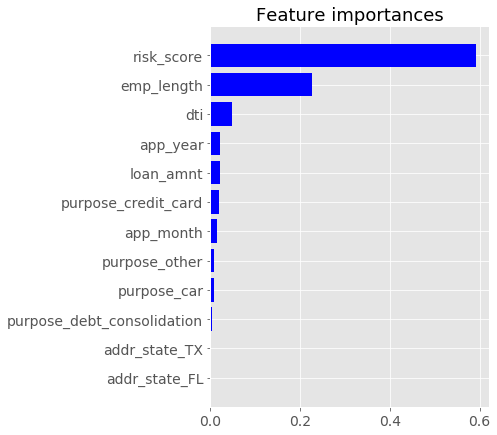

In [15]:
#print feature importance
features = X_train.columns
tree_importance=tree.feature_importances_

indices = np.argsort(tree_importance)[-12:]
plt.figure(figsize=(5, 7))
plt.title("Feature importances", fontsize = 18)
plt.barh(features[indices], tree_importance[indices],
       color="b",  align="center")
plt.tick_params(labelsize=14);

plt.show()

In [19]:
#feature importance
features = X_train.columns
tree_importance
tree_Top_15_feature=pd.DataFrame(list(zip(features,tree_importance)),columns=['Feature','Importance']).sort_values(by='Importance',ascending=False).head(12)
tree_Top_15_feature

,Feature,Importance
5,risk_score,0.592208
3,emp_length,0.227695
2,dti,0.049024
1,app_year,0.022364
4,loan_amnt,0.021279
58,purpose_credit_card,0.020208
0,app_month,0.015658
66,purpose_other,0.009049
57,purpose_car,0.008930
59,purpose_debt_consolidation,0.004412


 <p><a name="rf"></a></p>
 
 ### Random Forest

In [20]:

from sklearn.ensemble import RandomForestClassifier

# Create the model with 1000 trees
rand = RandomForestClassifier(n_estimators=1000, max_depth=10, n_jobs=-1)

# Fit on training data
rand.fit(X_train, y_train)
y_pred_rand = rand.predict(X_test)

print(f'Model Accuracy: {rand.score(X_train, y_train)}')
print("Test Accuracy:",metrics.accuracy_score(y_test, y_pred_rand))


Model Accuracy: 0.9507151282807431
Test Accuracy: 0.9492050229769248


[[19421   960]
 [ 1107 19205]]
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     20381
           1       0.95      0.95      0.95     20312

    accuracy                           0.95     40693
   macro avg       0.95      0.95      0.95     40693
weighted avg       0.95      0.95      0.95     40693



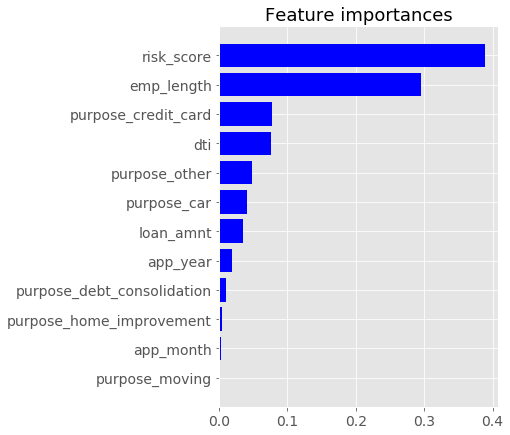

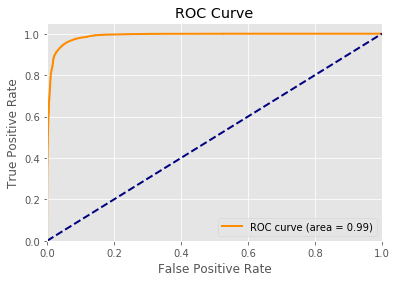

In [23]:

from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_test, y_pred_rand)
print(confusion_matrix)
print(classification_report(y_test, y_pred_rand))

# Actual class predictions
rf_predictions = rand.predict(X_test)
# Probabilities for each class
rf_probs = rand.predict_proba(X_test)[:, 1]

# Calculate roc auc
roc_value = roc_auc_score(y_test, rf_probs)
roc_value

#feature importance
features = X_train.columns
importance = rand.feature_importances_

indices = np.argsort(importance)[-12:]
plt.figure(figsize=(5, 7))
plt.title("Feature importances", fontsize = 18)
plt.barh(features[indices], importance[indices],
       color="b",  align="center")
plt.tick_params(labelsize=14);

plt.show()

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

y_predict_probabilities = rand.predict_proba(X_test)[:,1]

fpr, tpr, _ = roc_curve(y_test, y_predict_probabilities)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [25]:
#feature importance
features = X_train.columns
rand_importance=list(rand.feature_importances_)
rand_Top_15_feature=pd.DataFrame(list(zip(features,rand_importance)),columns=['Feature','Importance']).sort_values(by='Importance',ascending=False).head(12)
rand_Top_15_feature

,Feature,Importance
5,risk_score,0.388493
3,emp_length,0.294803
58,purpose_credit_card,0.077100
2,dti,0.075337
66,purpose_other,0.048814
57,purpose_car,0.040263
4,loan_amnt,0.035473
1,app_year,0.018528
59,purpose_debt_consolidation,0.009722
61,purpose_home_improvement,0.004306


#### random forest grid search


In [ ]:
#random search grid search
from sklearn.metrics import make_scorer, accuracy_score
clf = RandomForestClassifier()

parameters = {'n_estimators': [1000,1050], 
              'max_features': [7,10], 
              'criterion': [ 'gini'],
              'max_depth': [10]
             }

acc_scorer = make_scorer(accuracy_score)

grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train, y_train)
best_est = grid_obj.best_estimator_
print (best_est)

print(f'Model Accuracy: {grid_obj.score(X_train, y_train)}')
y_pred_random = grid_obj.predict(X_test)
print('test accuracy:',accuracy_score(y_test, y_pred_random))

from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_test, y_pred_random)
print(confusion_matrix)
print(classification_report(y_test, y_pred_random))

 <p><a name="svm"></a></p>
 
 ### SVM

In [26]:
svc = LinearSVC()
svc.fit(X_train, y_train)
y_pred_svc = svc.predict(X_test)

print(f'Model Accuracy: {svc.score(X_train, y_train)}')
print('test accuracy:',accuracy_score(y_test, y_pred_svc))


from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_test, y_pred_svc)
print(confusion_matrix)
print(classification_report(y_test, y_pred_svc))


C:\Users\Laptop2\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Model Accuracy: 0.8625896982207805
test accuracy: 0.8627282333570885
[[17199  3182]
 [ 2404 17908]]
              precision    recall  f1-score   support

           0       0.88      0.84      0.86     20381
           1       0.85      0.88      0.87     20312

    accuracy                           0.86     40693
   macro avg       0.86      0.86      0.86     40693
weighted avg       0.86      0.86      0.86     40693



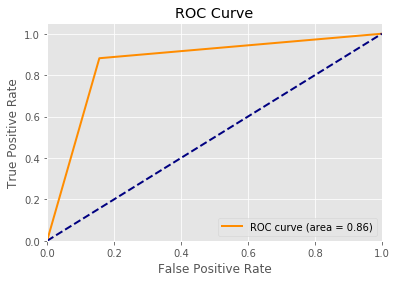

In [27]:
fpr, tpr, _ = roc_curve(y_test, y_pred_svc)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [28]:
#print feature importance

svc_coef=svc.coef_

svc_coef_list=list(svc_coef[0])
svc_feature=X_train.columns.to_list()
svc_Top_15_feature=pd.DataFrame(list(zip(svc_feature,svc_coef_list)),columns=['Feature','Coef']).sort_values(by='Coef',ascending=False).head(12)
svc_Top_15_feature


,Feature,Coef
3,emp_length,0.164993
58,purpose_credit_card,0.105109
59,purpose_debt_consolidation,0.032800
61,purpose_home_improvement,0.028495
63,purpose_major_purchase,0.015161
40,addr_state_NY,0.011568
69,purpose_vacation,0.010905
9,addr_state_AZ,0.006087
10,addr_state_CA,0.005721
11,addr_state_CO,0.005546


<BarContainer object of 12 artists>

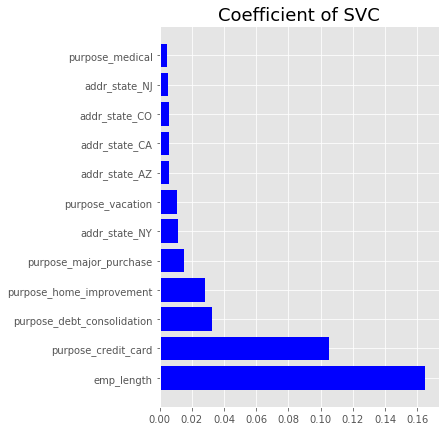

In [29]:

plt.figure(figsize=(5, 7))
plt.title("Coefficient of SVC", fontsize = 18)
plt.barh(svc_Top_15_feature["Feature"], svc_Top_15_feature["Coef"], color="b",  align="center")


In [ ]:
## Model accuracy for SVM is low so no need for grid search for SVM

# #### SVM Grid Search

# param_grid = {'C':[1,10,100,1000], 'penalty':['l2'], 'loss':['hinge']}
# grid_svm = GridSearchCV(LinearSVC(),param_grid,refit = True, verbose=2)
# grid_svm.fit(X_train,y_train)
# best_est_svc = grid_svm.best_estimator_
# print (best_est_svc)
# print(f'Model Accuracy: {grid_svm.score(X_train, y_train)}')
# y_pred_svc = grid_svm.predict(X_test)
# print('test accuracy:',accuracy_score(y_test, y_pred_svc))
# from sklearn.metrics import confusion_matrix

# confusion_matrix = confusion_matrix(y_test, y_pred_svc)
# print(confusion_matrix)
# print(classification_report(y_test, y_pred_svc))


 <p><a name="xgboost"></a></p>
 
 ### XGBoost

In [30]:
import xgboost as xgb


In [31]:
import xgboost as xgb
D_train = xgb.DMatrix(X_train, label=y_train)
D_test = xgb.DMatrix(X_test, label=y_test)
param = {
    'eta': 0.3, 
    'max_depth': 3,  
    'objective': 'multi:softprob',  
    'num_class': 2} 

steps = 20  # The number of training iterations

xg_model = xgb.train(param, D_train, steps)
preds_xg = xg_model.predict(D_test)
best_preds_xg = np.asarray([np.argmax(line) for line in preds_xg])

print("Precision = {}".format(precision_score(y_test, best_preds_xg, average='macro')))
print("Recall = {}".format(recall_score(y_test, best_preds_xg, average='macro')))
print("Accuracy = {}".format(accuracy_score(y_test, best_preds_xg)))


C:\Users\Laptop2\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Precision = 0.9510130474013685
Recall = 0.9509946355426564
Accuracy = 0.9509989433072027


In [32]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, best_preds_xg)
print(confusion_matrix)
print(classification_report(y_test, best_preds_xg))


[[19434   947]
 [ 1047 19265]]
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     20381
           1       0.95      0.95      0.95     20312

    accuracy                           0.95     40693
   macro avg       0.95      0.95      0.95     40693
weighted avg       0.95      0.95      0.95     40693



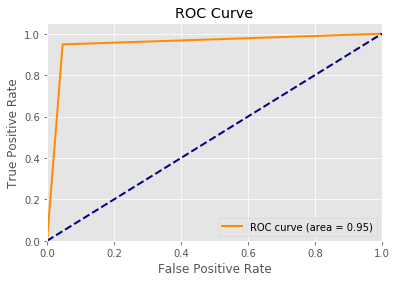

In [33]:
fpr, tpr, _ = roc_curve(y_test, best_preds_xg)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

##### Resources: 
##### Interprete feature importance in xg boost. https://towardsdatascience.com/be-careful-when-interpreting-your-features-importance-in-xgboost-6e16132588e7

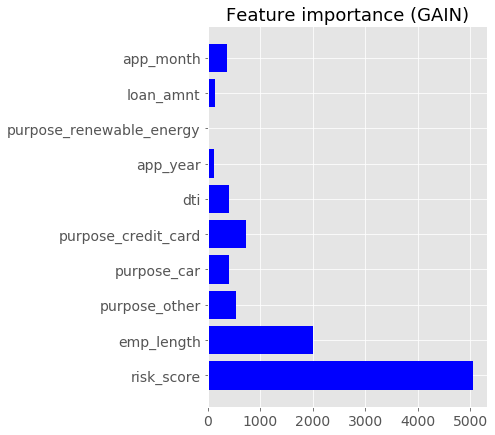

In [37]:
xg_feature_importance=xg_model.get_score(importance_type='gain')
plt.figure(figsize=(5, 7))
plt.title("Feature importance (GAIN)", fontsize = 18)
plt.barh(range(len(xg_feature_importance)), list(xg_feature_importance.values()),
       color="b",  align="center")
plt.tick_params(labelsize=14);
plt.yticks(range(len(xg_feature_importance)), list(xg_feature_importance.keys()))

plt.show()

#### grid search xg boost


In [ ]:
#grid search xg boost
clf = xgb.XGBClassifier()

# parameters = {
#      "eta"    : [0.10, 0.2 ] ,
#      "max_depth"        : [  12],
#      "min_child_weight" : [ 3, 5],
#      "gamma"            : [  0.2 , .5 ],
#      "colsample_bytree" : [ 0.3, .8 ]
#      }

parameters = {
     "eta"    : [ 0.20,.5,.7 ] ,
     "max_depth"        : [  10,15,20],
     "min_child_weight" : [ 3, 5 ,7],
     "gamma"            : [  0.2 , 0.3 ,0.7],
     "colsample_bytree" : [  0.5 ,.7,.8 ]
     }

grid = GridSearchCV(clf,
                    parameters, n_jobs=4,
                    scoring="neg_log_loss",
                    cv=3)

grid.fit(X_train, y_train)


In [ ]:
preds = grid.predict(X_test)
best_preds = np.asarray([np.argmax(line) for line in preds])

print("Precision = {}".format(precision_score(y_test, best_preds, average='macro')))
print("Recall = {}".format(recall_score(y_test, best_preds, average='macro')))
print("Accuracy = {}".format(accuracy_score(y_test, best_preds)))

 <p><a name="logistic"></a></p>
 
 ### Logistic Regression
 
- Links: https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8

C:\Users\Laptop2\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy of logistic regression classifier on test set: 0.89
[[17714  2667]
 [ 1765 18547]]
              precision    recall  f1-score   support

           0       0.91      0.87      0.89     20381
           1       0.87      0.91      0.89     20312

    accuracy                           0.89     40693
   macro avg       0.89      0.89      0.89     40693
weighted avg       0.89      0.89      0.89     40693



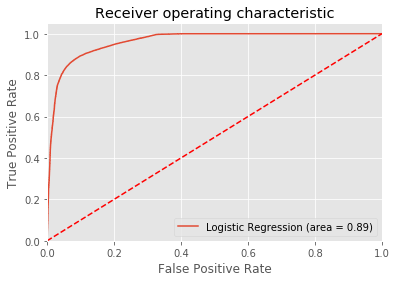

In [38]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_test, logreg.predict(X_test))

print(confusion_matrix)

print(classification_report(y_test, y_pred))

logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()


<BarContainer object of 12 artists>

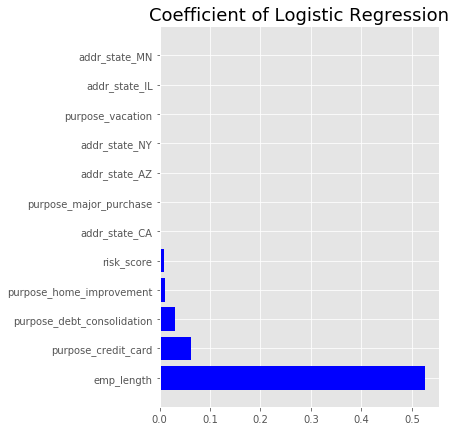

In [42]:
logistic_coef=logreg.coef_

logistic_coef_list=list(logistic_coef[0])
logistic_feature=X_train.columns.to_list()
Top_15_feature=pd.DataFrame(list(zip(logistic_feature,logistic_coef_list)),columns=['Features','Importance']).sort_values(by='Importance',ascending=False).head(12)


plt.figure(figsize=(5, 7))
plt.title("Coefficient of Logistic Regression", fontsize = 18)
plt.barh(Top_15_feature['Features'], Top_15_feature['Importance'], color="b",  align="center")


In [43]:
Top_15_feature

,Features,Importance
3,emp_length,0.526639
58,purpose_credit_card,0.063074
59,purpose_debt_consolidation,0.030546
61,purpose_home_improvement,0.010154
5,risk_score,0.009152
10,addr_state_CA,0.002846
63,purpose_major_purchase,0.002591
9,addr_state_AZ,0.001839
40,addr_state_NY,0.001027
69,purpose_vacation,0.000887


## Naive Bayes

Accuracy of Naive Bayes on test set: 0.85
[[14338  6043]
 [  228 20084]]
              precision    recall  f1-score   support

           0       0.98      0.70      0.82     20381
           1       0.77      0.99      0.86     20312

    accuracy                           0.85     40693
   macro avg       0.88      0.85      0.84     40693
weighted avg       0.88      0.85      0.84     40693



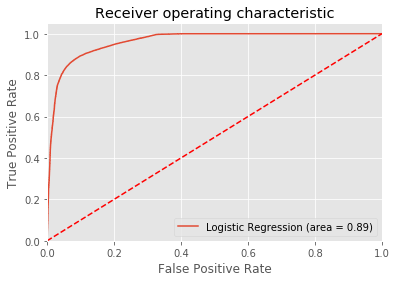

In [46]:
from sklearn.naive_bayes import GaussianNB

#Create a Gaussian Classifier
model = GaussianNB()

# Train the model using the training sets
model.fit(X_train, y_train)

#Predict Output
y_pred = model.predict(X_test) 

print('Accuracy of Naive Bayes on test set: {:.2f}'.format(model.score(X_test, y_test)))


from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)
print(classification_report(y_test, y_pred))



logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

### Nearest Neighbor

In [47]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
X_train_scaler  = scaler.fit_transform(X_train)
X_test_scaler  = scaler.fit_transform(X_test)
# from sklearn.decomposition import PCA



from sklearn.neighbors import KNeighborsClassifier

k = 2

knn_model = KNeighborsClassifier(n_neighbors=k)
knn_model.fit(X_train_scaler, y_train) 
y_pred = knn_model.predict(X_test_scaler)
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)
print(classification_report(y_test, y_pred))


[[19472   909]
 [ 2579 17733]]
              precision    recall  f1-score   support

           0       0.88      0.96      0.92     20381
           1       0.95      0.87      0.91     20312

    accuracy                           0.91     40693
   macro avg       0.92      0.91      0.91     40693
weighted avg       0.92      0.91      0.91     40693



### Use best params found by random forest on the untouched test set. 

In [ ]:
#read the test set. note: test set is already balanced. 
test_set_from_accepted_raw=pd.read_csv('test_set_from_accepted_raw.csv',index_col=0)
test_set_from_reject_downsampled=pd.read_csv('test_set_from_reject_downsampled.csv', index_col=0)
df_processed = data_process(test_set_from_accepted_raw, test_set_from_reject_downsampled)
x_Test=df_processed.drop(["loan_status"],axis=1)
y_Test=df_processed['loan_status']


In [10]:

#use the grid search best param from random forest to predict x_Test

preds = grid_obj.predict(x_Test)
best_preds = np.asarray([np.argmax(line) for line in preds])

print("Precision = {}".format(precision_score(y_Test, best_preds, average='macro')))
print("Recall = {}".format(recall_score(y_Test, best_preds, average='macro')))
print("Accuracy = {}".format(accuracy_score(y_Test, best_preds)))

### Use best params found by xg boost on the untouched test set. 

In [ ]:
x_Test=df_processed.drop(["loan_status"],axis=1)
y_Test=df_processed['loan_status']

#use the grid search best param from random forest to predict x_Test


y_pred_random = grid.predict(x_Test)
print('test accuracy:',accuracy_score(y_Test, y_pred_random))

from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_Test, y_pred_random)
print(confusion_matrix)
print(classification_report(y_Test, y_pred_random))
